## Download data via API

In [1]:
import requests

# Example URL for a traffic dataset (change date/month as needed)
url = 'https://datos.madrid.es/egob/catalogo/208627-148-transporte-ptomedida-historico.zip'

response = requests.get(url)
if response.status_code == 200:
    with open('septiembre.zip', 'wb') as f:
        f.write(response.content)
    print("Download complete!")
else:
    print("Download failed. Status code:", response.status_code)


Download complete!


In [4]:
import os
# Unzip the downloaded file
# importing the zipfile module
from zipfile import ZipFile

# loading the septiembre.zip and creating a zip object
with ZipFile("septiembre.zip", 'r') as zObject:

    # Extracting all the members of the zip 
    # into a specific location.
    # check if the file already exists to avoid overwriting
    if os.path.exists("/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/"):
        print("Data folder already exists. Skipping extraction.")
    else:
        zObject.extractall(path="/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/")
    
# delete the zip file after extraction
import os
os.remove("septiembre.zip")


Data folder already exists. Skipping extraction.


## Get overview

In [50]:
# load data into pandas dataframe
import pandas as pd
import numpy as np

data = pd.read_csv('/Users/annakober/Desktop/Uni/Master/Erasmus/Programming_cities/ciudades_sostenibles/data/09-2025.csv', sep=';')

# explore data
data.info()
data.describe()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13082675 entries, 0 to 13082674
Data columns (total 9 columns):
 #   Column               Dtype  
---  ------               -----  
 0   id                   int64  
 1   fecha                object 
 2   tipo_elem            object 
 3   intensidad           int64  
 4   ocupacion            int64  
 5   carga                int64  
 6   vmed                 float64
 7   error                object 
 8   periodo_integracion  int64  
dtypes: float64(1), int64(5), object(3)
memory usage: 898.3+ MB


,id,fecha,tipo_elem,intensidad,ocupacion,carga,vmed,error,periodo_integracion
0,1006,2025-09-01 00:00:00,C30,660,2,0,60.0,N,5
1,1006,2025-09-01 00:15:00,C30,324,1,0,60.0,N,5
2,1006,2025-09-01 00:30:00,C30,228,0,0,63.0,N,5
3,1006,2025-09-01 00:45:00,C30,96,0,0,61.0,N,5
4,1006,2025-09-01 01:00:00,C30,264,1,0,61.0,N,5


In [51]:
## transform and clean up dataframe 
# convert column fecha to datetime
data["fecha"] = pd.to_datetime(data["fecha"])
data = data.set_index("fecha")

# check for errors and remove them
print("Number of non optimal or errouneous observations:", len(data[data["error"] != "N"]))
data = data[data["error"] == "N"] # keep only good observations

# create column with total number of cars per 15 minute period
data["coches_total"] = data["intensidad"] / 4



Number of non optimal or errouneous observations: 76336


## Get statistical overview 

In [79]:
# calculate mode
def mode(series):
    mode_result = series.mode()
    return mode_result.iloc[0] if len(mode_result) > 0 else series.median()


# calculate sensor statistics
def sensor_statistics(data, sensor, aggregation_period = None):

    if sensor in ["M30", "C30"]:
        # filter dataframe
        data_m30 = data[(data["tipo_elem"] == "C30") | (data["tipo_elem"] == "M30")]

        # Resampling but only for numeric columsn
        if aggregation_period is not None:
            # get numeric columns
            numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
            # keep id column to group by
            data_m30 = data_m30.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)
        
        # aggregate dataframe 
        data_m30_agg = data_m30.groupby("id").agg({
            "intensidad": ["min", "max", "mean", "median"], 
            "vmed": ["min", "max", "mean", "median"]
        })
        
        # Modus für jeden Sensor berechnen
        intensity_modes = data_m30.groupby("id")["intensidad"].apply(mode)
        speed_modes = data_m30.groupby("id")["vmed"].apply(mode)
        
        print("M30/C30 statistics")

        # print sensor with minimum and maximum intensity
        print(f"Sensor id with minimum intensity {data_m30_agg["intensidad"]["min"].idxmin()}")
        print(f"Sensor id with maximum intensity {data_m30_agg["intensidad"]["max"].idxmax()}")
        
        # find closest sensor 
        for stat in ["mean", "median"]:
            for char in ["intensidad", "vmed"]:
                overall_stat = data_m30_agg[char][stat].mean()
                closest_sensor = abs(data_m30_agg[char][stat] - overall_stat).idxmin()
                print(f"Sensor id closest to {stat} {char}: {closest_sensor} (value: {overall_stat:.1f})")
        
        # closest sensor to mode 
        intensity_overall_mode = intensity_modes.mean()
        speed_overall_mode = speed_modes.mean()
        
        closest_sensor_intensity_mode = abs(intensity_modes - intensity_overall_mode).idxmin()
        closest_sensor_speed_mode = abs(speed_modes - speed_overall_mode).idxmin()
        
        print(f"Sensor id closest to mode intensidad: {closest_sensor_intensity_mode} (value: {intensity_overall_mode:.1f})")
        print(f"Sensor id closest to mode vmed: {closest_sensor_speed_mode} (value: {speed_overall_mode:.1f})")

    elif sensor == "URB":
        data_urbano = data[data["tipo_elem"] == "URB"]

        # Resampling
        if aggregation_period is not None:
            numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
            data_urbano = data_urbano.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)

        # aggregate dataframe
        data_urbano_agg = data_urbano.groupby("id").agg({
            "intensidad": ["min", "max", "mean", "median"], 
            "vmed": ["min", "max", "mean", "median"]
        })
        
        intensity_modes = data_urbano.groupby("id")["intensidad"].apply(mode)

        print("urban sensor statistics")

        # print sensor with minimum and maximum intensity
        print(f"Sensor id with minimum intensity {data_urbano_agg["intensidad"]["min"].idxmin()}")
        print(f"Sensor id with maximum intensity {data_urbano_agg["intensidad"]["max"].idxmax()}")
        
        # find closest sensor
        for stat in ["mean", "median"]:
            overall_stat = data_urbano_agg["intensidad"][stat].mean()
            closest_sensor = abs(data_urbano_agg["intensidad"][stat] - overall_stat).idxmin()
            print(f"Sensor id closest to {stat} intensity: {closest_sensor} (value: {overall_stat:.1f})")
        
        # Modus
        overall_mode = intensity_modes.mean()
        closest_sensor_mode = abs(intensity_modes - overall_mode).idxmin()
        print(f"Sensor id closest to mode intensity: {closest_sensor_mode} (value: {overall_mode:.1f})")

    else:
        print(f"unknown sensor type: {sensor}")
        return None

In [80]:
sensor_statistics(data, "M30", aggregation_period=None)

M30/C30 statistics
Sensor id with minimum intensity 1006
Sensor id with maximum intensity 6842
Sensor id closest to mean intensidad: 3495 (value: 1164.5)
Sensor id closest to mean vmed: 6640 (value: 60.6)
Sensor id closest to median intensidad: 6771 (value: 1297.8)
Sensor id closest to median vmed: 3542 (value: 64.2)
Sensor id closest to mode intensidad: 6747 (value: 475.3)
Sensor id closest to mode vmed: 3532 (value: 64.2)


## Create statistics function for plotting

In [ ]:
def get_relevant_sensors(data, sensor_type, aggregation_period = None):
    """Create statitsics for all sensors and save relevant sensor ids in dictionary for further plotting"""
    
    if sensor_type in ["M30", "C30"]:
        print(f"\n Relevant statistic for sensor type M30 with aggregation period: {aggregation_period}")
        data_filtered = data[(data["tipo_elem"] == "C30") | (data["tipo_elem"] == "M30")]
    elif sensor_type == "URB":
        print(f"\n Relevant statistic for sensor type URB with aggregation period: {aggregation_period}")
        data_filtered = data[data["tipo_elem"] == "URB"]
    else:
        return None
    
    # Resampling but only for numeric columsn
    if aggregation_period is not None:
        # get numeric columns
        numeric_cols = ["intensidad", "vmed", "ocupacion", "carga", "coches_total"]
        # keep id column to group by
        data_filtered = data_filtered.groupby("id")[numeric_cols].resample(aggregation_period).mean().reset_index(level=0)

    # Aggregierte Statistiken berechnen
    data_agg = data_filtered.groupby("id").agg({
        "intensidad": ["min", "max", "mean", "median"], 
        "vmed": ["min", "max", "mean", "median"]
    })
    
    # Modus berechnen
    def safe_mode(series):
        mode_result = series.mode()
        return mode_result.iloc[0] if len(mode_result) > 0 else series.median()
    
    intensity_modes = data_filtered.groupby("id")["intensidad"].apply(safe_mode)
    
    # Relevante Sensoren sammeln
    relevant_sensors = {
        'min_intensity': data_agg["intensidad"]["min"].idxmin(),
        'max_intensity': data_agg["intensidad"]["max"].idxmax(),
        'mean_intensity': abs(data_agg["intensidad"]["mean"] - data_agg["intensidad"]["mean"].mean()).idxmin(),
        'median_intensity': abs(data_agg["intensidad"]["median"] - data_agg["intensidad"]["median"].mean()).idxmin(),
        'mode_intensity': abs(intensity_modes - intensity_modes.mean()).idxmin(),
        'mean_speed': abs(data_agg["vmed"]["mean"] - data_agg["vmed"]["mean"].mean()).idxmin()
    }

    ## print statistics
    # print sensor with minimum and maximum intensity
    print(f"Sensor id with minimum intensity {relevant_sensors['min_intensity']}")
    print(f"Sensor id with maximum intensity {relevant_sensors['max_intensity']}")

    # print sensors closest to mean and median value
    for stat in ["mean", "median"]:
        for char in ["intensidad", "vmed"]:
            overall_stat = data_agg[char][stat].mean()
            closest_sensor = abs(data_agg[char][stat] - overall_stat).idxmin()
            print(f"Sensor id closest to {stat} {char}: {closest_sensor} (value: {overall_stat:.1f})")

    # print sensors closest to mode
    # closest sensor to mode 
    if sensor_type in ["M30", "C30"]:
        speed_modes = data_filtered.groupby("id")["vmed"].apply(safe_mode)
        speed_overall_mode = speed_modes.mean()
        closest_sensor_speed_mode = abs(speed_modes - speed_overall_mode).idxmin()
        print(f"Sensor id closest to mode vmed: {closest_sensor_speed_mode} (value: {speed_overall_mode:.1f})")

    print(f"Sensor id closest to mode intensidad: {relevant_sensors['mode_intensity']} (value: {intensity_modes.mean():.1f})")
    
    return relevant_sensors, data_filtered

# Relevante Sensoren für M30/C30 und URB identifizieren
m30_sensors, m30_data = get_relevant_sensors(data, "M30", aggregation_period = None)
urb_sensors, urb_data = get_relevant_sensors(data, "URB", aggregation_period = None)



 Relevant statistic for sensor type M30 with aggregation period: None
Sensor id with minimum intensity 1006
Sensor id with maximum intensity 6842
Sensor id closest to mean intensidad: 3495 (value: 1164.5)
Sensor id closest to mean vmed: 6640 (value: 60.6)
Sensor id closest to median intensidad: 6771 (value: 1297.8)
Sensor id closest to median vmed: 3542 (value: 64.2)
Sensor id closest to mode vmed: 3532 (value: 64.2)
Sensor id closest to mode intensidad: 6747 (value: 475.3)

 Relevant statistic for sensor type URB with aggregation period: None
Sensor id with minimum intensity 3395
Sensor id with maximum intensity 3624
Sensor id closest to mean intensidad: 11107 (value: 288.0)
Sensor id closest to mean vmed: 3395 (value: 0.0)
Sensor id closest to median intensidad: 5331 (value: 300.3)
Sensor id closest to median vmed: 3395 (value: 0.0)
Sensor id closest to mode intensidad: 3623 (value: 211.6)


### Plot data

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
from datetime import datetime

def plot_sensor_traffic(data, sensor_id, sensor_type, date=None):
    """
    visualize data for specific sensor
    """
    
    # Sensor-Daten filtern
    sensor_data = data[data['id'] == sensor_id].copy()
    
    if sensor_data.empty:
        print(f"No data for {sensor_id}")
        return
    
    # Spezifisches Datum wählen (wenn nicht angegeben, nimm den ersten Tag mit Daten)
    if date is None:
        date = sensor_data.index.date[0]
    
    # Daten für einen Tag filtern
    daily_data = sensor_data[sensor_data.index.date == pd.to_datetime(date).date()]
    
    if daily_data.empty:
        print(f"No data for {sensor_id} on the {date}")
        return
    
    # Resample für 15 Minuten und 1 Stunde
    data_15min = daily_data#.resample('15min').agg({
    #     'intensidad': 'mean',
    #     'vmed': 'mean',
    #     'coches_total': 'sum'
    # })
    
    data_1hour = daily_data.resample('H').agg({
        'intensidad': 'mean', 
        'vmed': 'mean',
        'coches_total': 'sum'
    })
    
    # Plot erstellen
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle(f'Verkehrsdaten Sensor {sensor_id} ({sensor_type}) - {date}', fontsize=16)
    
    # 15-Minuten Intervalle - Fahrzeuganzahl
    axes[0, 0].plot(data_15min.index, data_15min['coches_total'], 
                    marker='o', linewidth=2, markersize=4, color='blue')
    axes[0, 0].set_title('Fahrzeuganzahl (15-Min Intervalle)')
    axes[0, 0].set_ylabel('Anzahl Fahrzeuge')
    axes[0, 0].grid(True, alpha=0.3)
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # 15-Minuten Intervalle - Geschwindigkeit
    axes[0, 1].plot(data_15min.index, data_15min['vmed'], 
                    marker='s', linewidth=2, markersize=4, color='red')
    axes[0, 1].set_title('Durchschnittsgeschwindigkeit (15-Min Intervalle)')
    axes[0, 1].set_ylabel('Geschwindigkeit (km/h)')
    axes[0, 1].grid(True, alpha=0.3)
    axes[0, 1].tick_params(axis='x', rotation=45)
    
    # 1-Stunden Intervalle - Fahrzeuganzahl
    axes[1, 0].bar(range(len(data_1hour)), data_1hour['coches_total'], 
                   color='skyblue', alpha=0.7, edgecolor='blue')
    axes[1, 0].set_title('Fahrzeuganzahl (1-Stunden Intervalle)')
    axes[1, 0].set_ylabel('Anzahl Fahrzeuge')
    axes[1, 0].set_xlabel('Stunde des Tages')
    axes[1, 0].set_xticks(range(len(data_1hour)))
    axes[1, 0].set_xticklabels([f"{hour:02d}:00" for hour in data_1hour.index.hour])
    axes[1, 0].grid(True, alpha=0.3, axis='y')
    
    # 1-Stunden Intervalle - Geschwindigkeit
    axes[1, 1].bar(range(len(data_1hour)), data_1hour['vmed'], 
                   color='salmon', alpha=0.7, edgecolor='red')
    axes[1, 1].set_title('Durchschnittsgeschwindigkeit (1-Stunden Intervalle)')
    axes[1, 1].set_ylabel('Geschwindigkeit (km/h)')
    axes[1, 1].set_xlabel('Stunde des Tages')
    axes[1, 1].set_xticks(range(len(data_1hour)))
    axes[1, 1].set_xticklabels([f"{hour:02d}:00" for hour in data_1hour.index.hour])
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    plt.tight_layout()
    plt.show()
    
    # Statistiken ausgeben
    print(f"\n=== STATISTIKEN SENSOR {sensor_id} am {date} ===")
    print(f"Gesamte Fahrzeuge: {daily_data['coches_total'].sum():.0f}")
    print(f"Peak-Stunde (Fahrzeuge): {data_1hour['coches_total'].idxmax().strftime('%H:00')} ({data_1hour['coches_total'].max():.0f} Fahrzeuge)")
    print(f"Durchschnittsgeschwindigkeit: {daily_data['vmed'].mean():.1f} km/h")
    print(f"Niedrigste Geschwindigkeit: {daily_data['vmed'].min():.1f} km/h um {daily_data['vmed'].idxmin().strftime('%H:%M')}")
    print(f"Höchste Geschwindigkeit: {daily_data['vmed'].max():.1f} km/h um {daily_data['vmed'].idxmax().strftime('%H:%M')}")

Analysiere M30-Sensor mit höchster Intensität: 6842


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


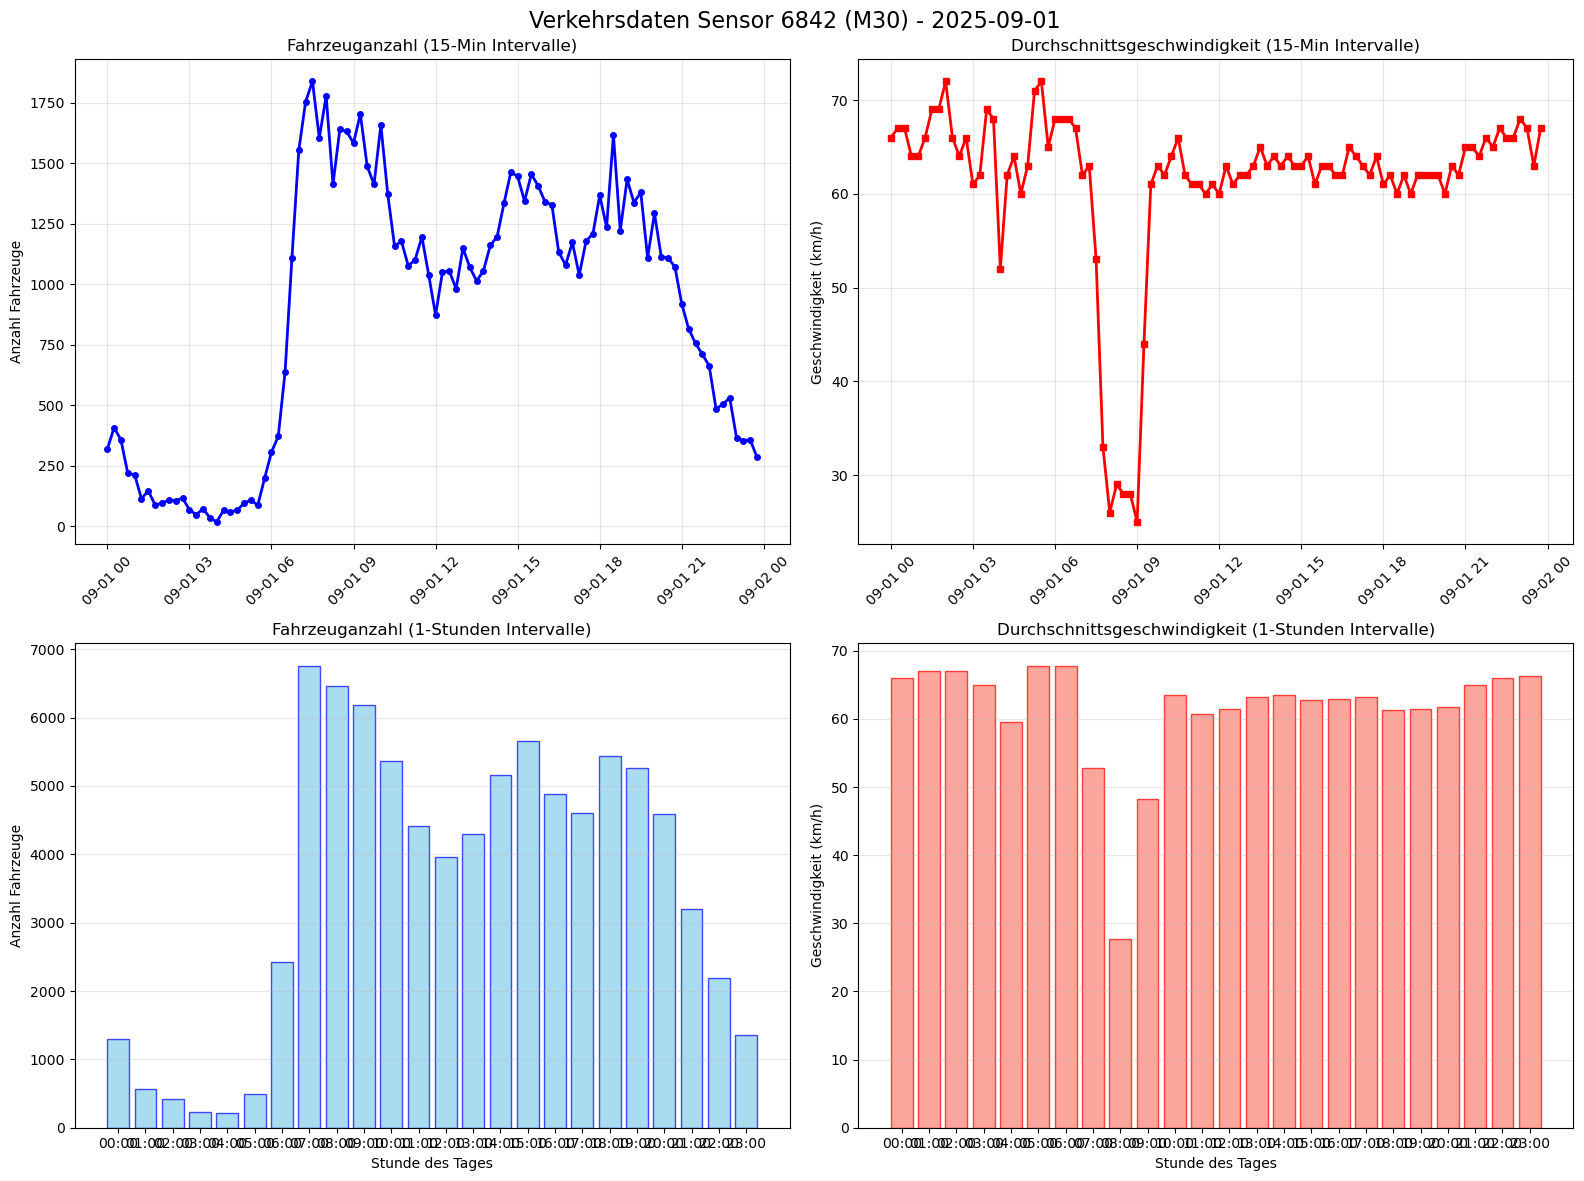


=== STATISTIKEN SENSOR 6842 am 2025-09-01 ===
Gesamte Fahrzeuge: 85411
Peak-Stunde (Fahrzeuge): 07:00 (6753 Fahrzeuge)
Durchschnittsgeschwindigkeit: 61.3 km/h
Niedrigste Geschwindigkeit: 25.0 km/h um 09:00
Höchste Geschwindigkeit: 72.0 km/h um 02:00
Analysiere URB-Sensor mit durchschnittlicher Intensität: 11107


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


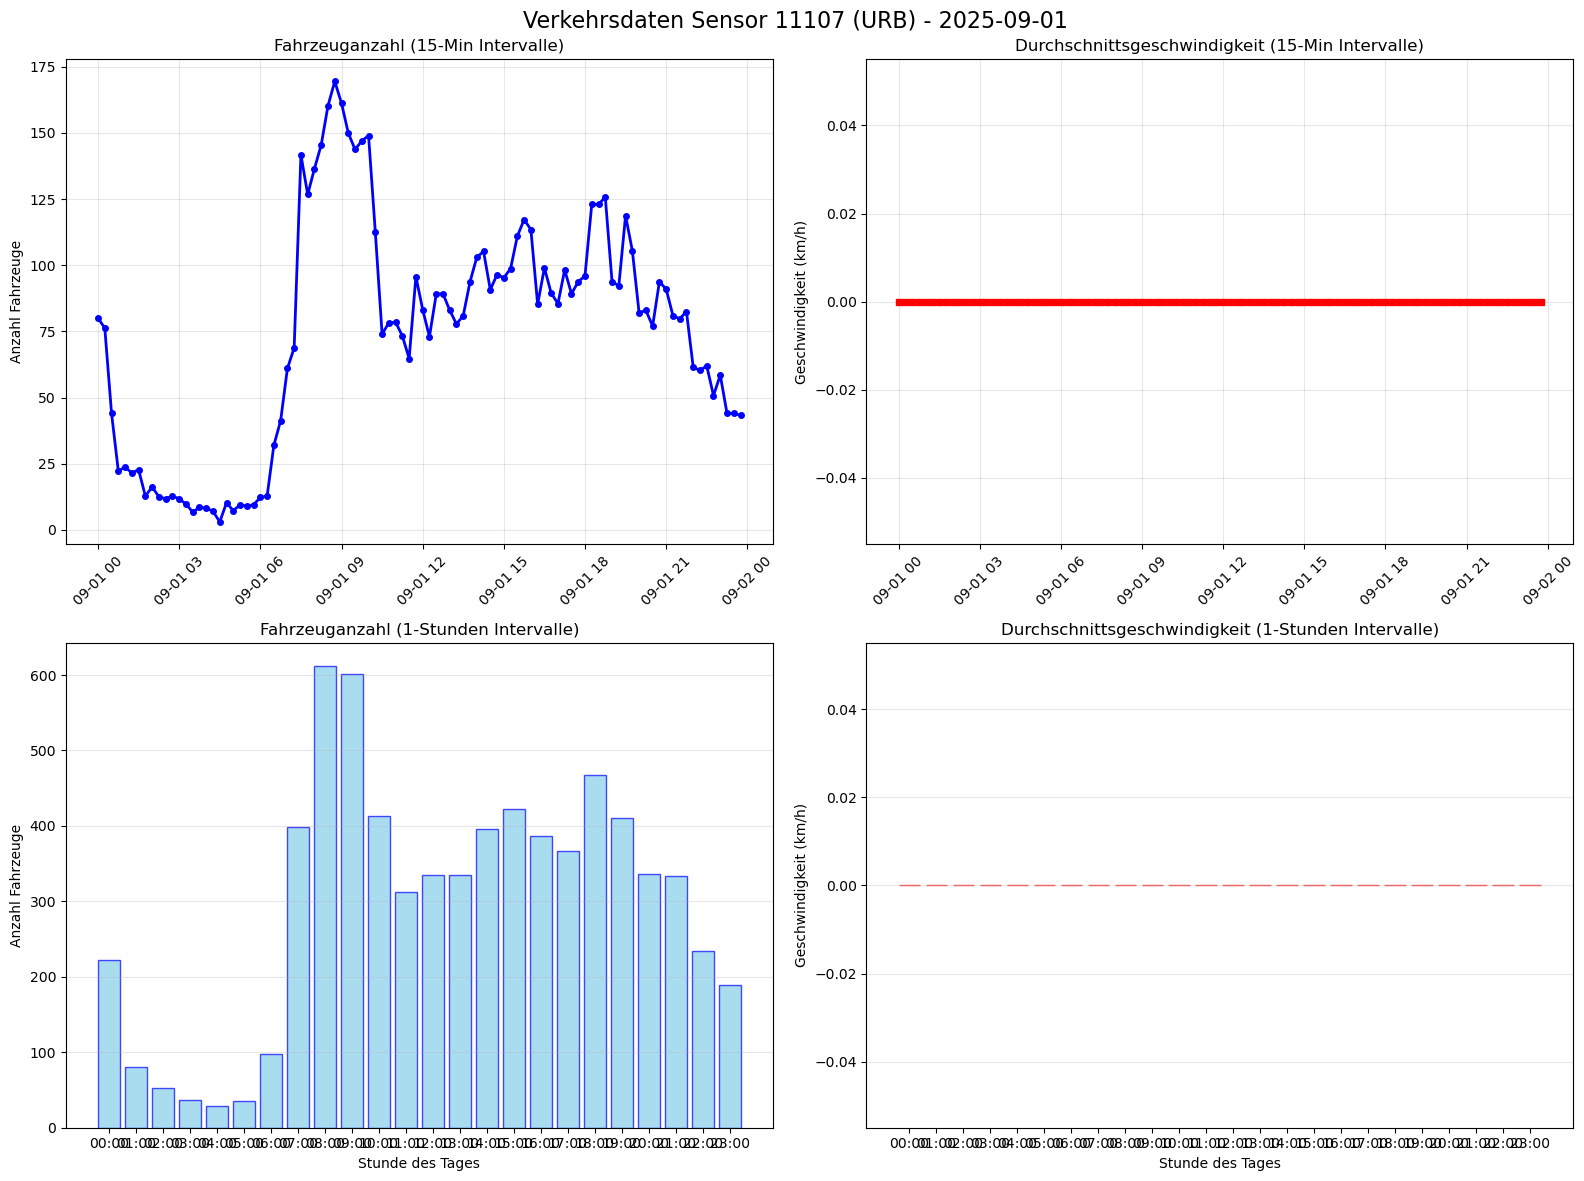


=== STATISTIKEN SENSOR 11107 am 2025-09-01 ===
Gesamte Fahrzeuge: 7107
Peak-Stunde (Fahrzeuge): 08:00 (612 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 00:00
Höchste Geschwindigkeit: 0.0 km/h um 00:00


In [84]:
# Beispiel: Plot für den Sensor mit höchster Intensität (M30)
if m30_sensors:
    sensor_id = m30_sensors['max_intensity']
    print(f"Analysiere M30-Sensor mit höchster Intensität: {sensor_id}")
    plot_sensor_traffic(m30_data, sensor_id, "M30")

# Beispiel: Plot für den repräsentativsten urbanen Sensor
if urb_sensors:
    sensor_id = urb_sensors['mean_intensity'] 
    print(f"Analysiere URB-Sensor mit durchschnittlicher Intensität: {sensor_id}")
    plot_sensor_traffic(urb_data, sensor_id, "URB")


=== ANALYSE ALLER RELEVANTEN M30 SENSOREN ===

--- MIN_INTENSITY: Sensor 1006 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


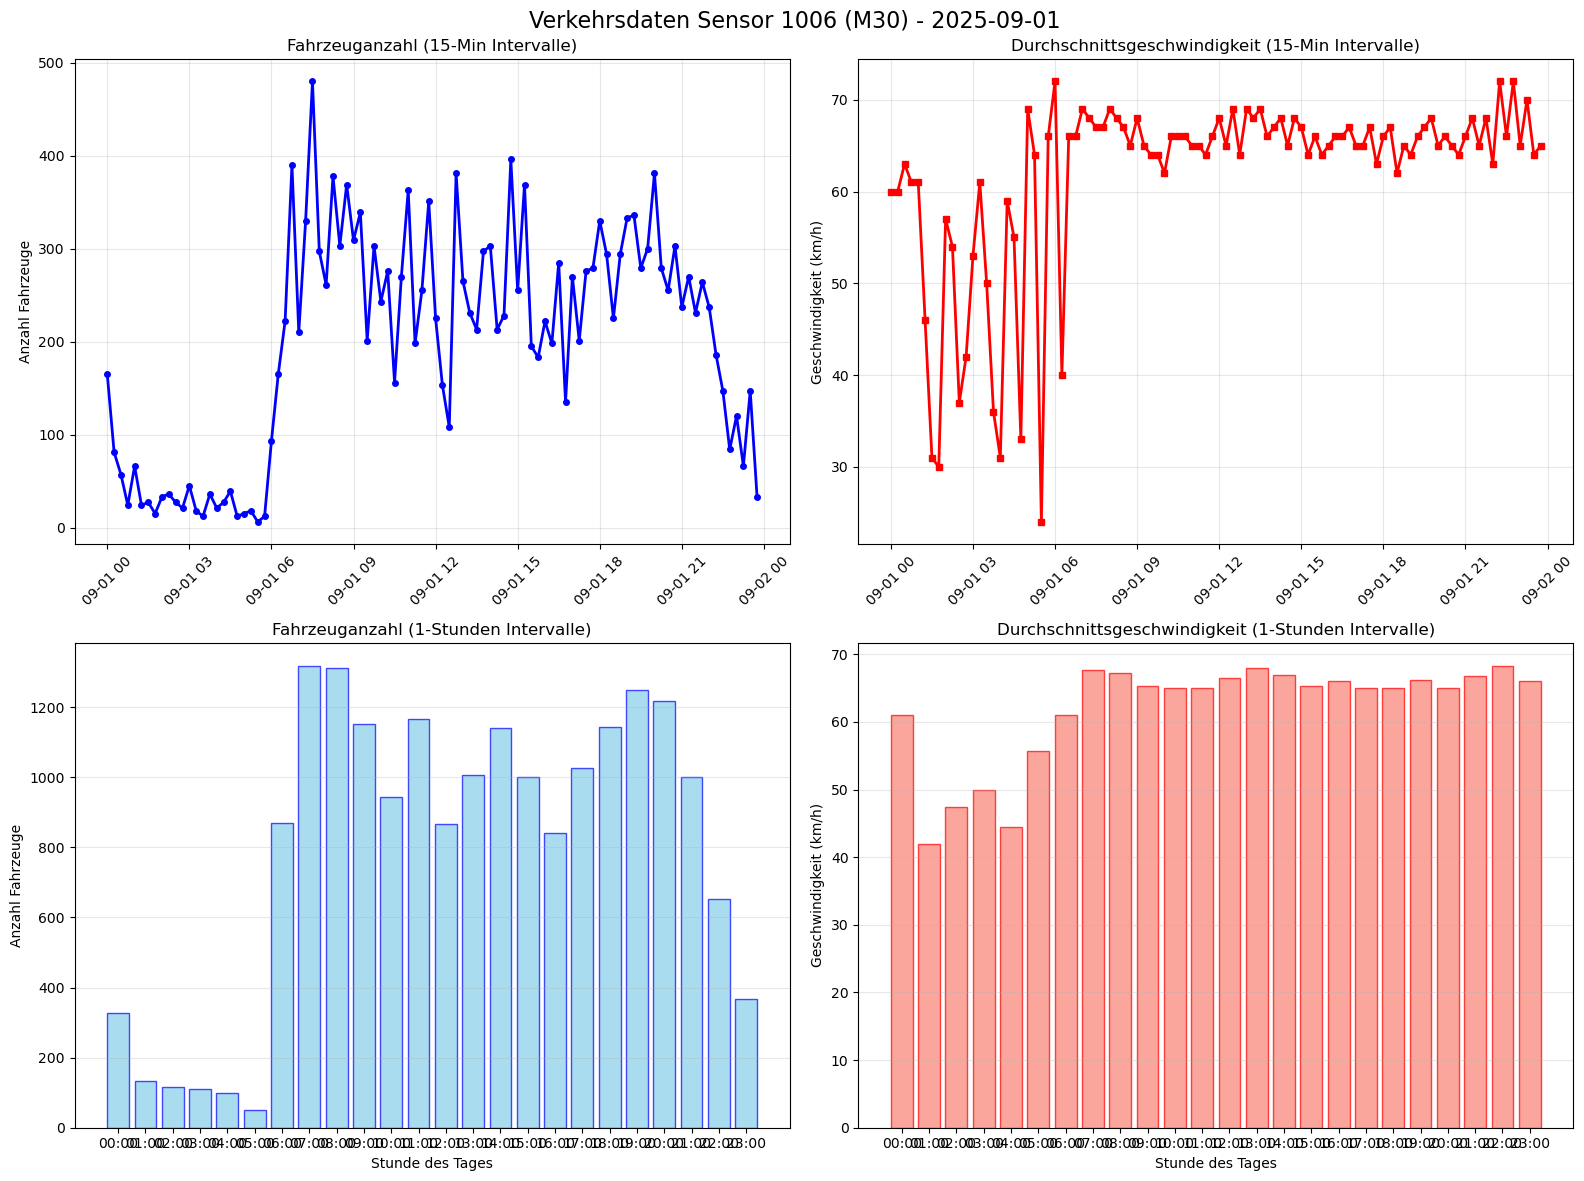


=== STATISTIKEN SENSOR 1006 am 2025-09-01 ===
Gesamte Fahrzeuge: 19111
Peak-Stunde (Fahrzeuge): 07:00 (1317 Fahrzeuge)
Durchschnittsgeschwindigkeit: 62.0 km/h
Niedrigste Geschwindigkeit: 24.0 km/h um 05:30
Höchste Geschwindigkeit: 72.0 km/h um 06:00

--- MAX_INTENSITY: Sensor 6842 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


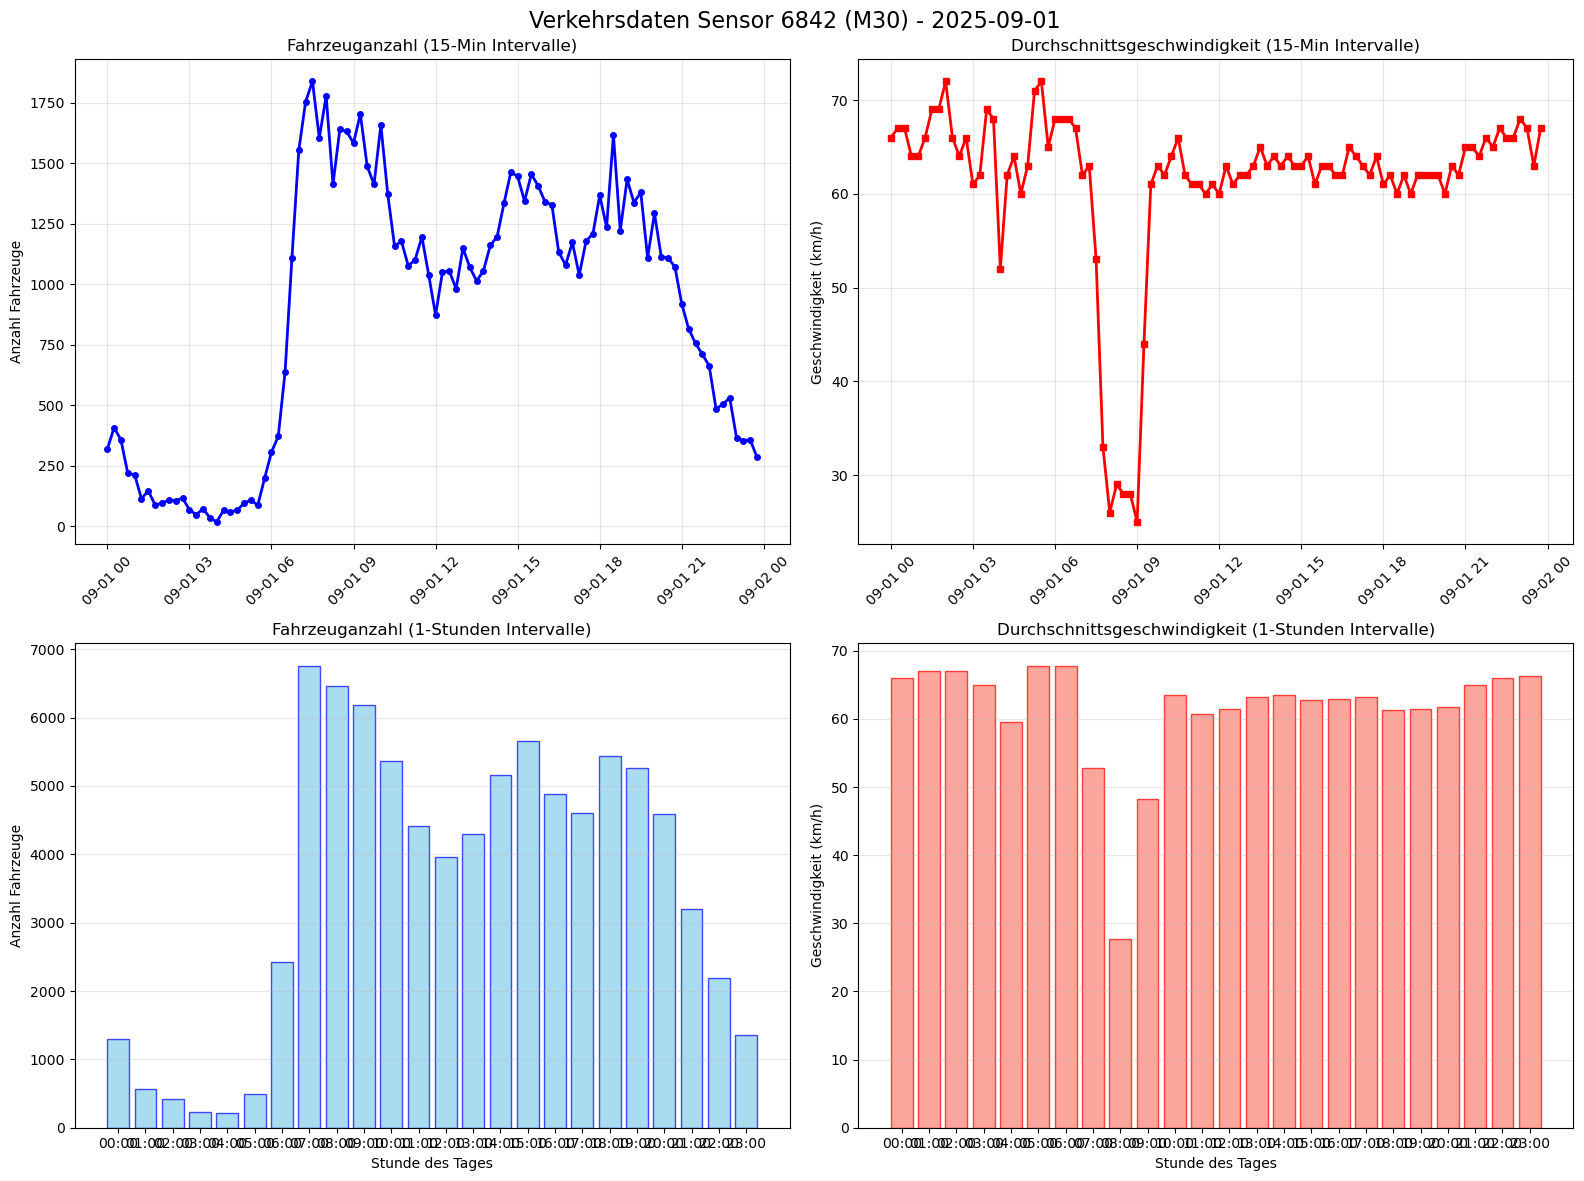


=== STATISTIKEN SENSOR 6842 am 2025-09-01 ===
Gesamte Fahrzeuge: 85411
Peak-Stunde (Fahrzeuge): 07:00 (6753 Fahrzeuge)
Durchschnittsgeschwindigkeit: 61.3 km/h
Niedrigste Geschwindigkeit: 25.0 km/h um 09:00
Höchste Geschwindigkeit: 72.0 km/h um 02:00

--- MEAN_INTENSITY: Sensor 3495 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


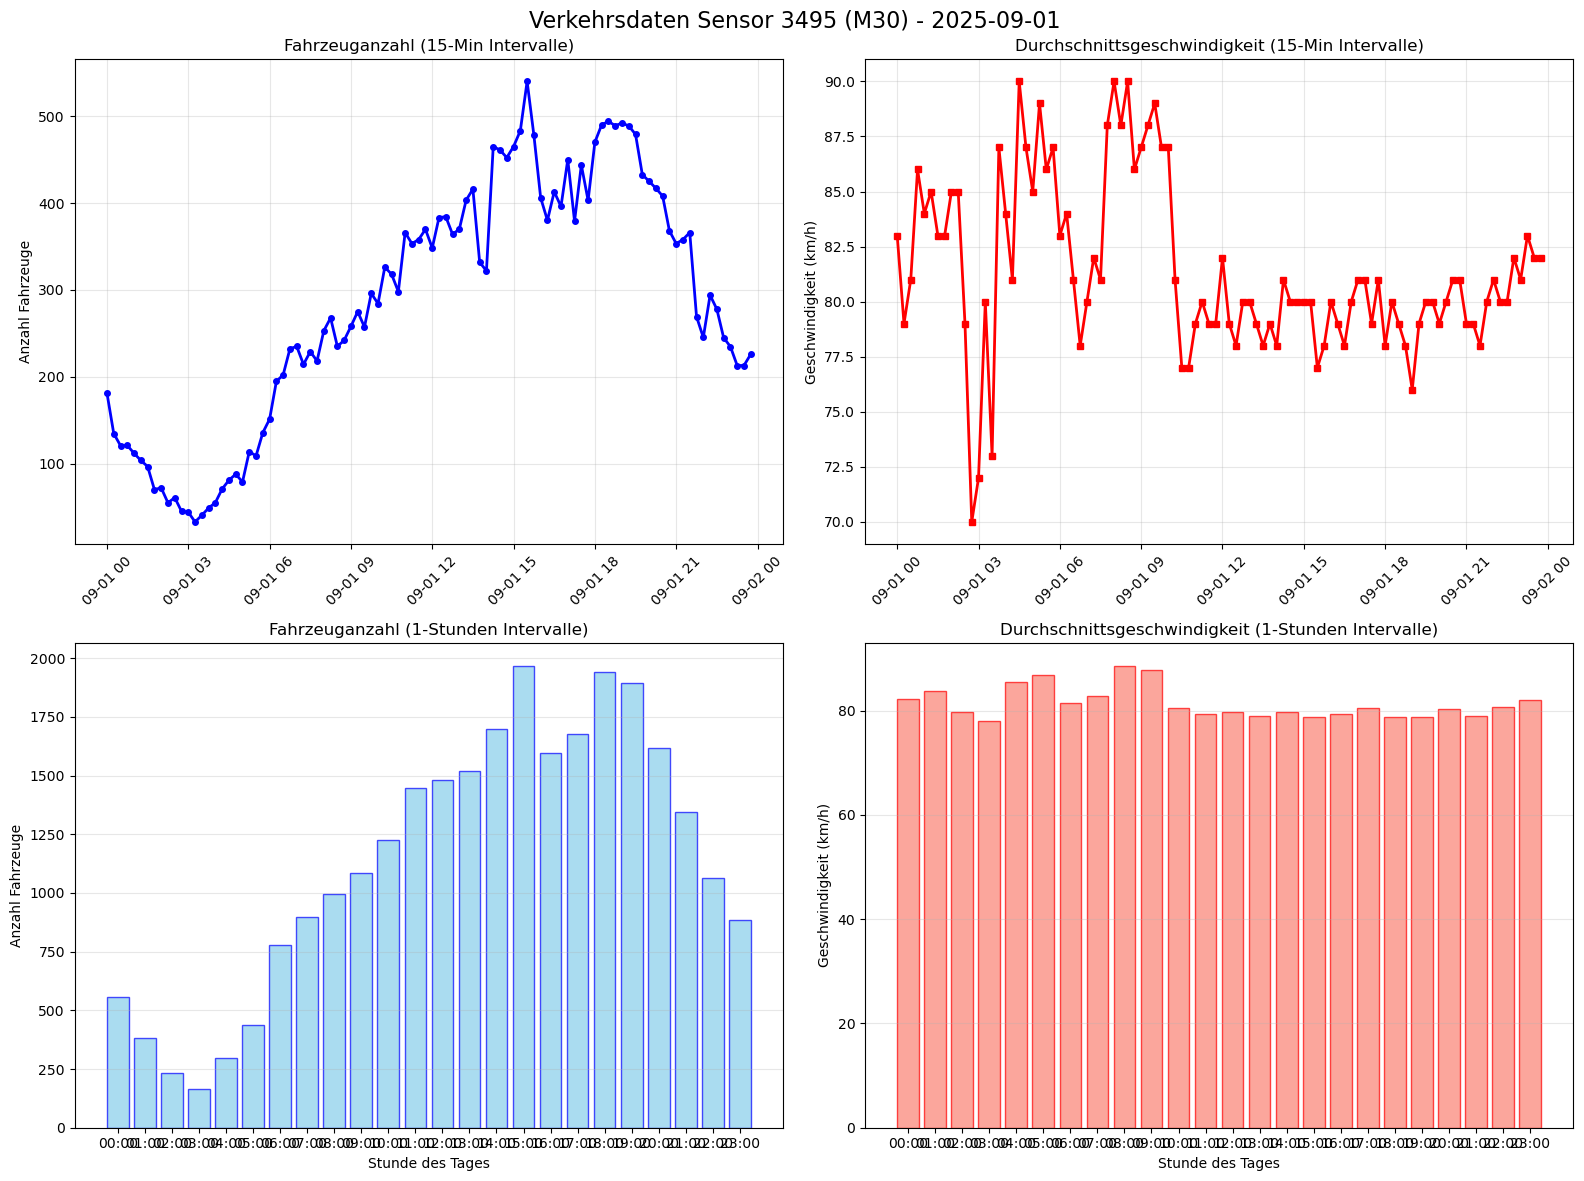


=== STATISTIKEN SENSOR 3495 am 2025-09-01 ===
Gesamte Fahrzeuge: 27195
Peak-Stunde (Fahrzeuge): 15:00 (1966 Fahrzeuge)
Durchschnittsgeschwindigkeit: 81.4 km/h
Niedrigste Geschwindigkeit: 70.0 km/h um 02:45
Höchste Geschwindigkeit: 90.0 km/h um 04:30

--- MEDIAN_INTENSITY: Sensor 6771 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


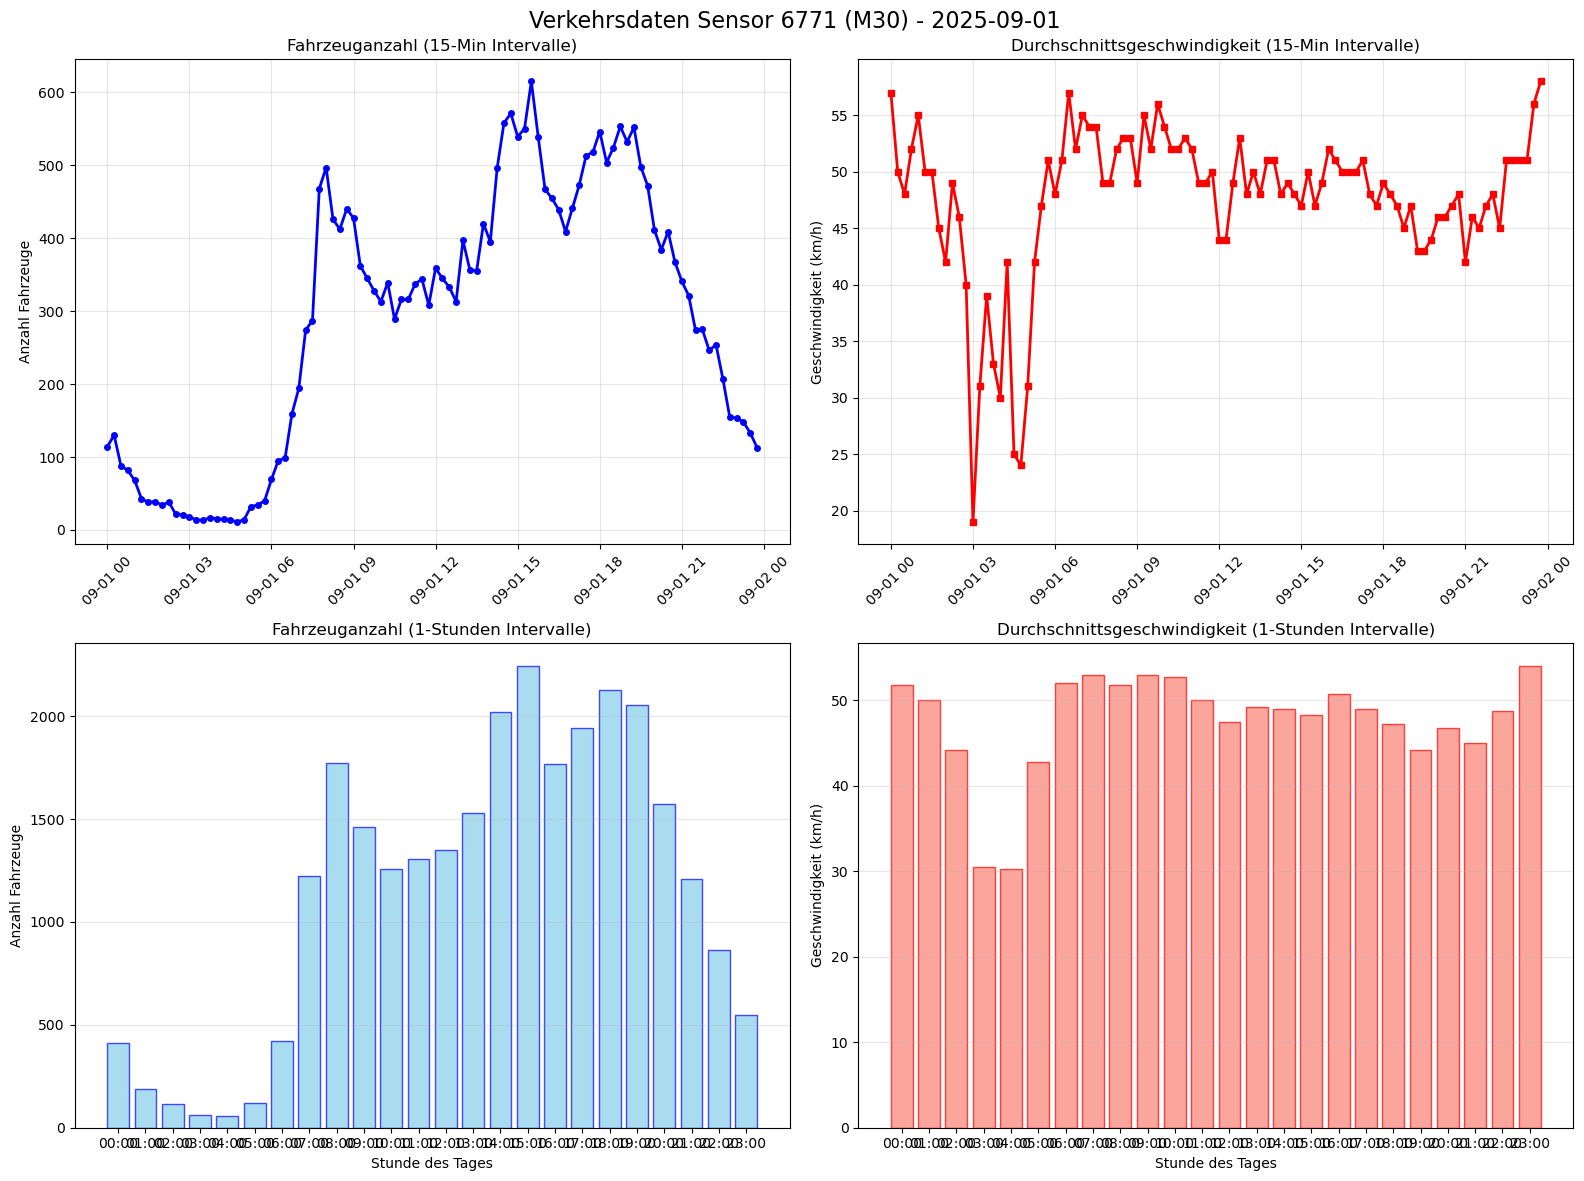


=== STATISTIKEN SENSOR 6771 am 2025-09-01 ===
Gesamte Fahrzeuge: 27630
Peak-Stunde (Fahrzeuge): 15:00 (2243 Fahrzeuge)
Durchschnittsgeschwindigkeit: 47.6 km/h
Niedrigste Geschwindigkeit: 19.0 km/h um 03:00
Höchste Geschwindigkeit: 58.0 km/h um 23:45

--- MODE_INTENSITY: Sensor 6747 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


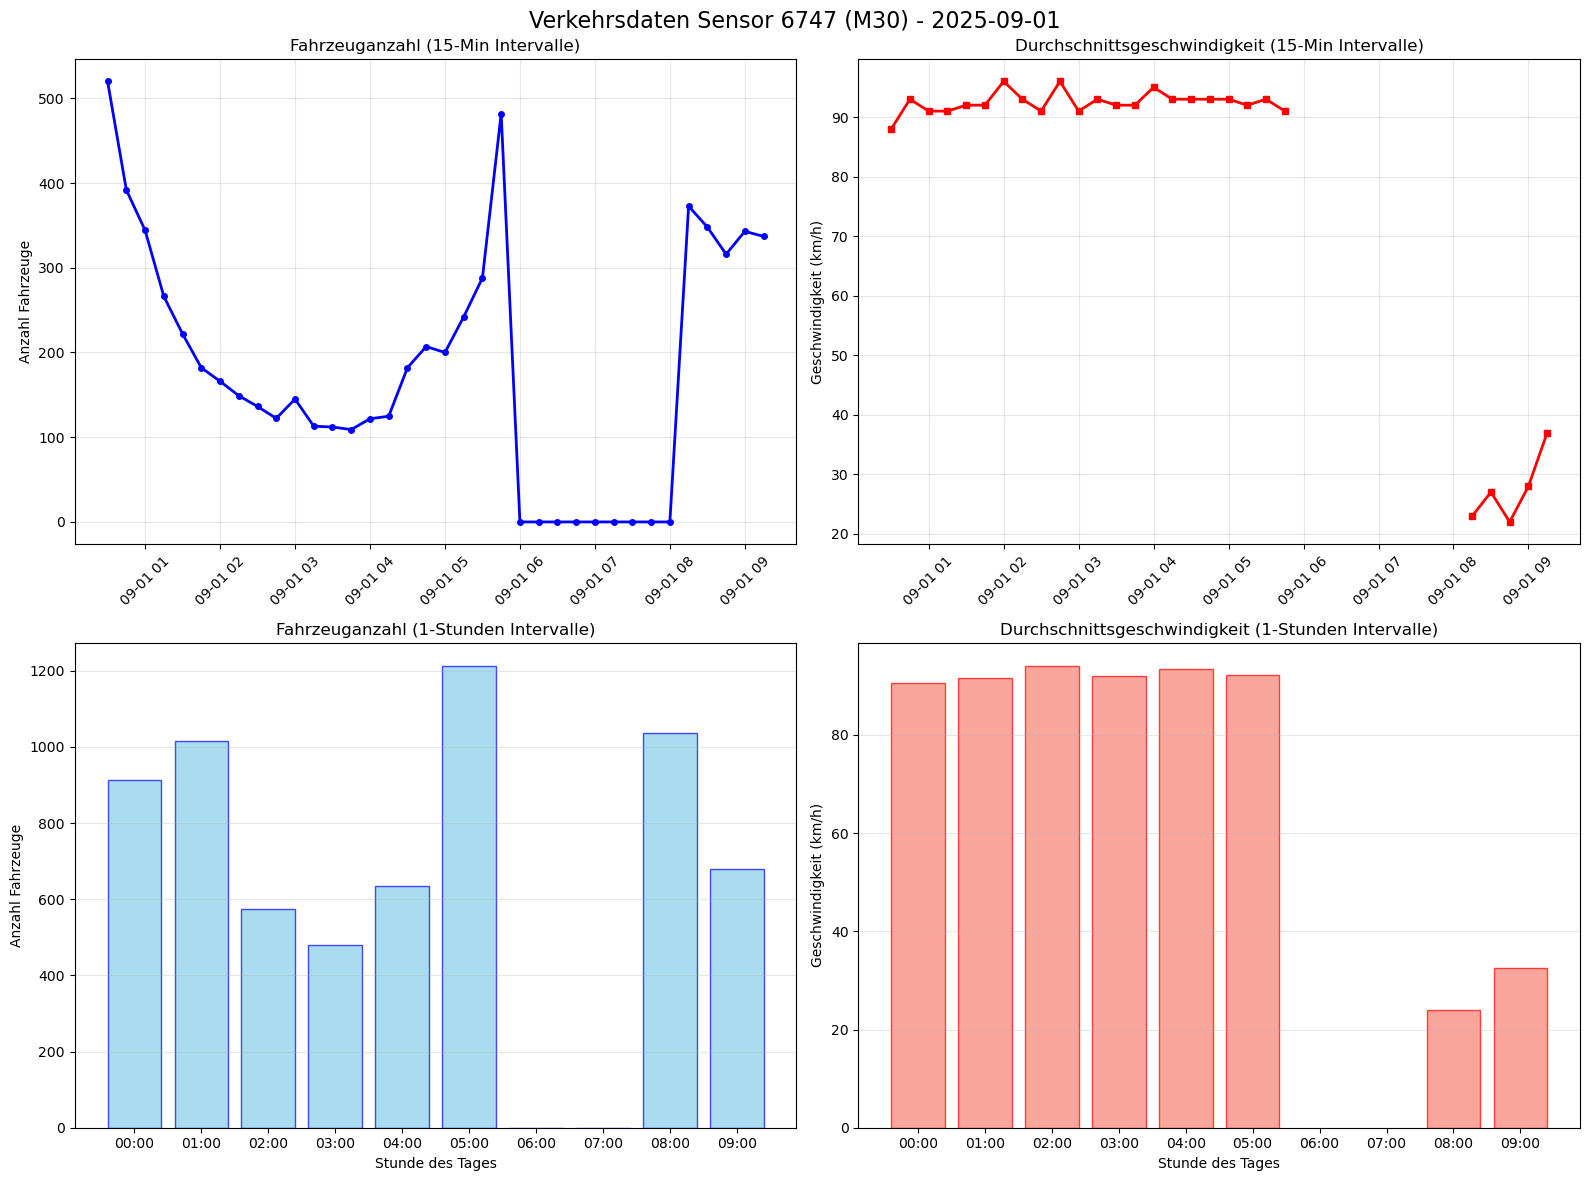

/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({



=== STATISTIKEN SENSOR 6747 am 2025-09-01 ===
Gesamte Fahrzeuge: 6543
Peak-Stunde (Fahrzeuge): 05:00 (1212 Fahrzeuge)
Durchschnittsgeschwindigkeit: 80.4 km/h
Niedrigste Geschwindigkeit: 22.0 km/h um 08:45
Höchste Geschwindigkeit: 96.0 km/h um 02:00

--- MEAN_SPEED: Sensor 6640 ---


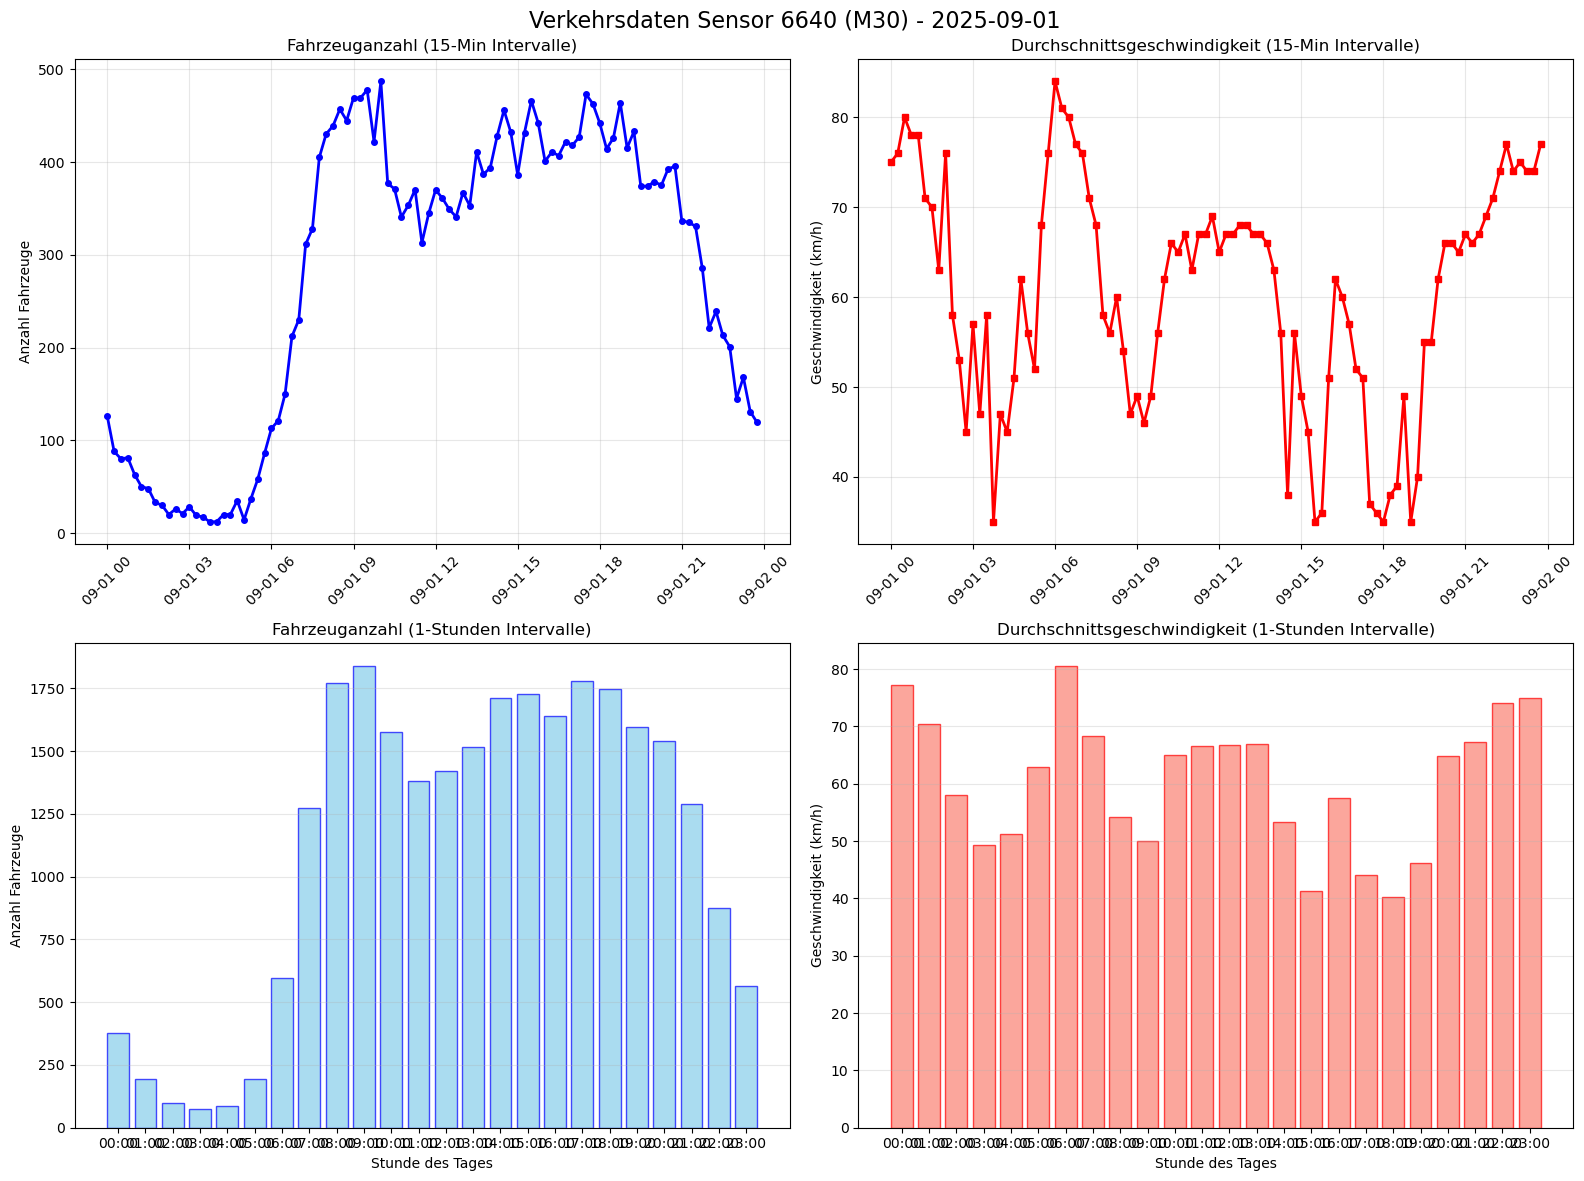


=== STATISTIKEN SENSOR 6640 am 2025-09-01 ===
Gesamte Fahrzeuge: 26868
Peak-Stunde (Fahrzeuge): 09:00 (1838 Fahrzeuge)
Durchschnittsgeschwindigkeit: 60.5 km/h
Niedrigste Geschwindigkeit: 35.0 km/h um 03:45
Höchste Geschwindigkeit: 84.0 km/h um 06:00

=== ANALYSE ALLER RELEVANTEN URB SENSOREN ===

--- MIN_INTENSITY: Sensor 3395 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


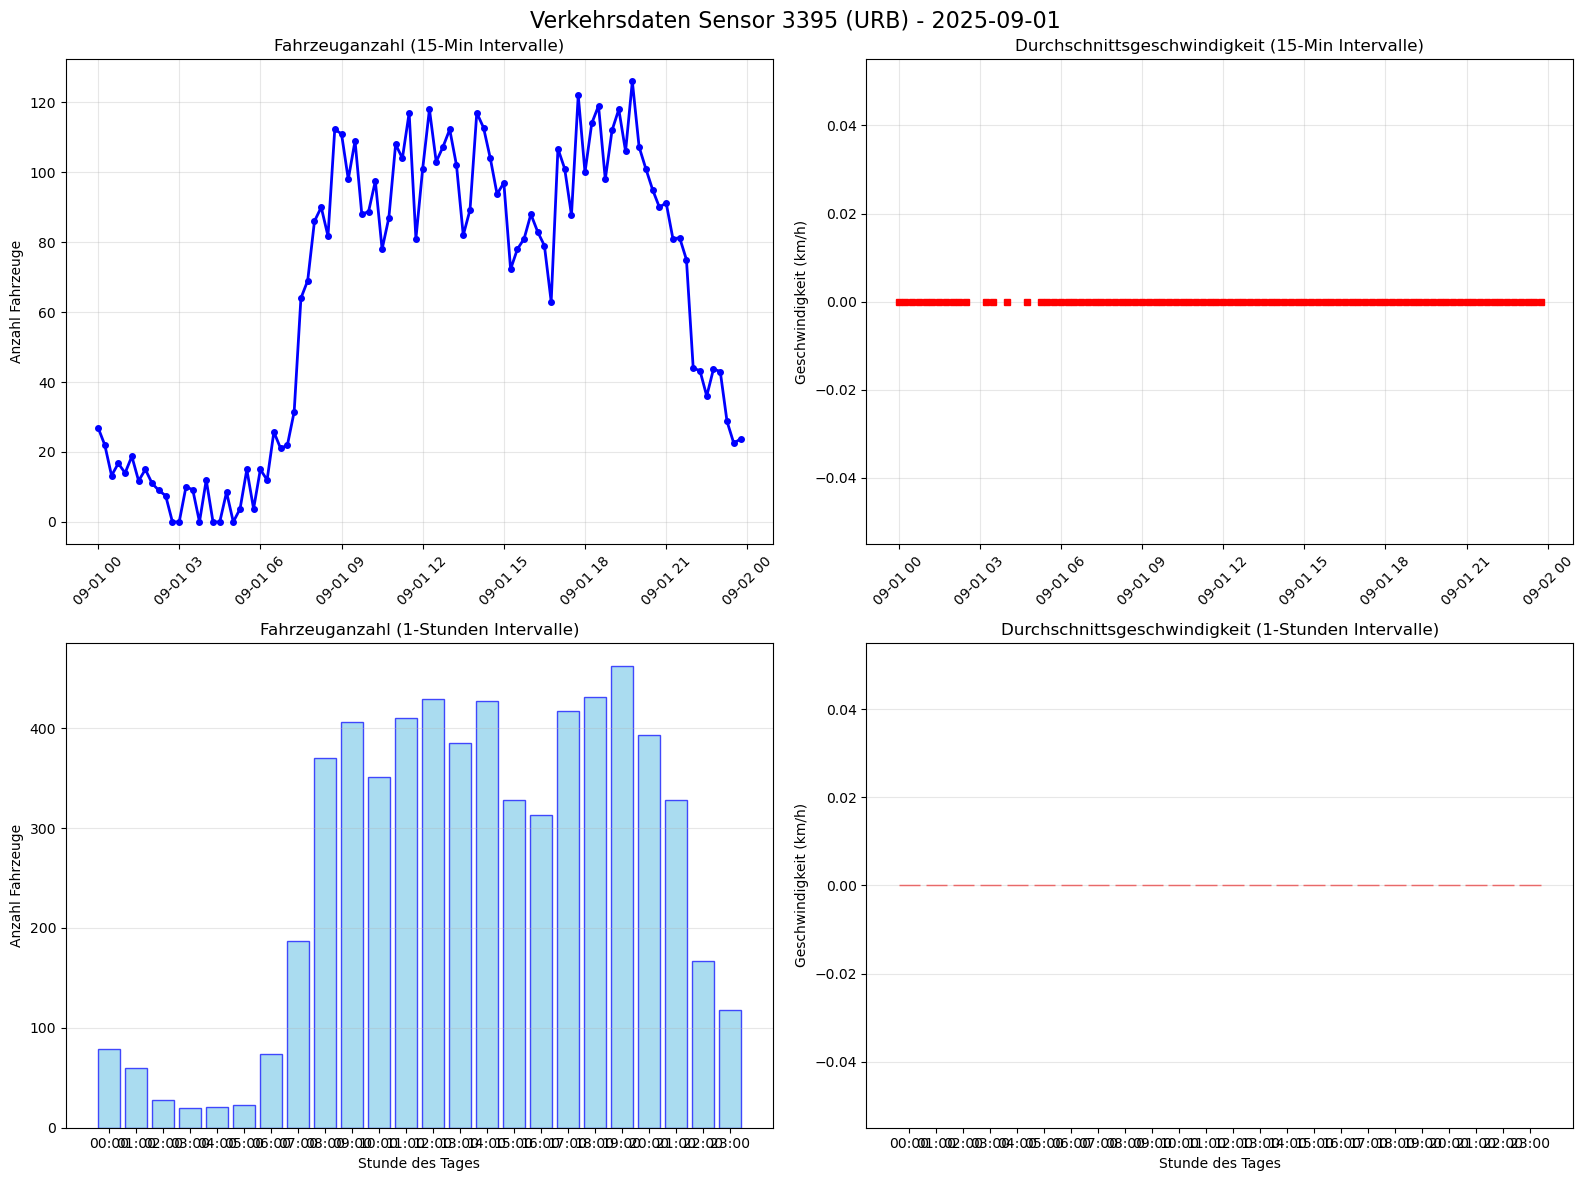


=== STATISTIKEN SENSOR 3395 am 2025-09-01 ===
Gesamte Fahrzeuge: 6226
Peak-Stunde (Fahrzeuge): 19:00 (462 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 00:00
Höchste Geschwindigkeit: 0.0 km/h um 00:00

--- MAX_INTENSITY: Sensor 3624 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


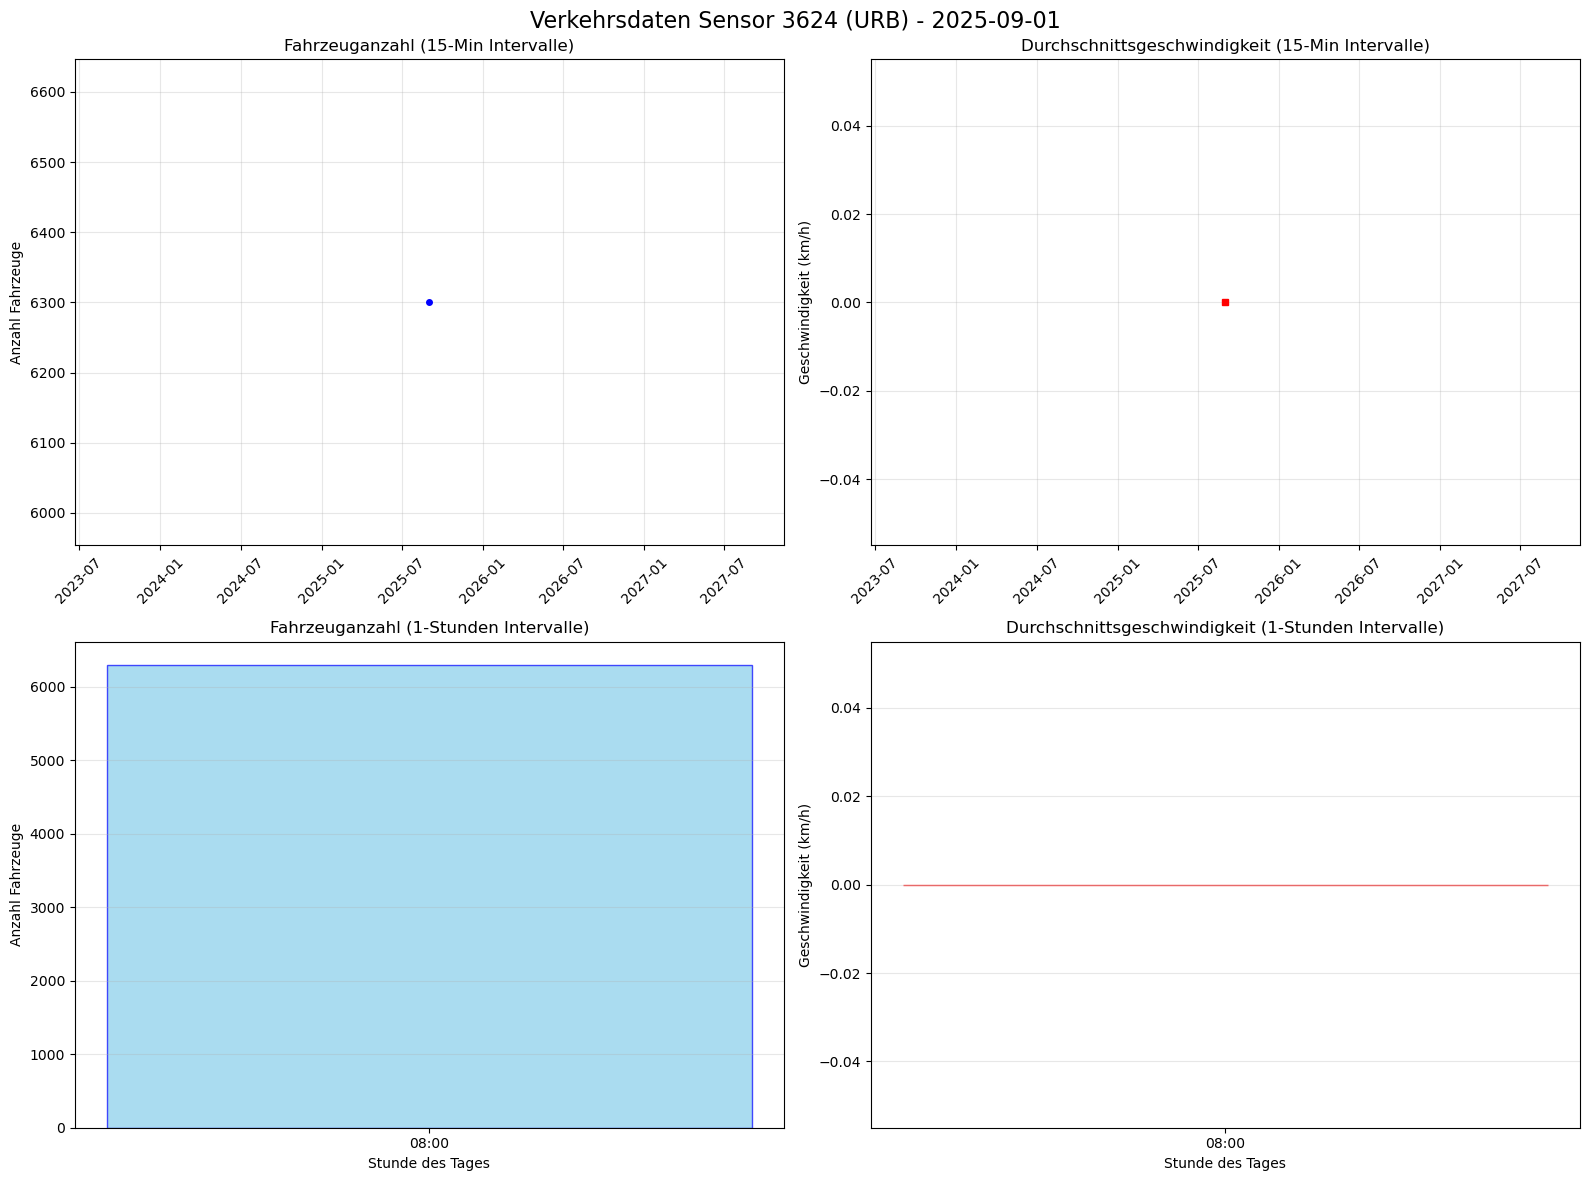

/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({



=== STATISTIKEN SENSOR 3624 am 2025-09-01 ===
Gesamte Fahrzeuge: 6300
Peak-Stunde (Fahrzeuge): 08:00 (6300 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 08:30
Höchste Geschwindigkeit: 0.0 km/h um 08:30

--- MEAN_INTENSITY: Sensor 11107 ---


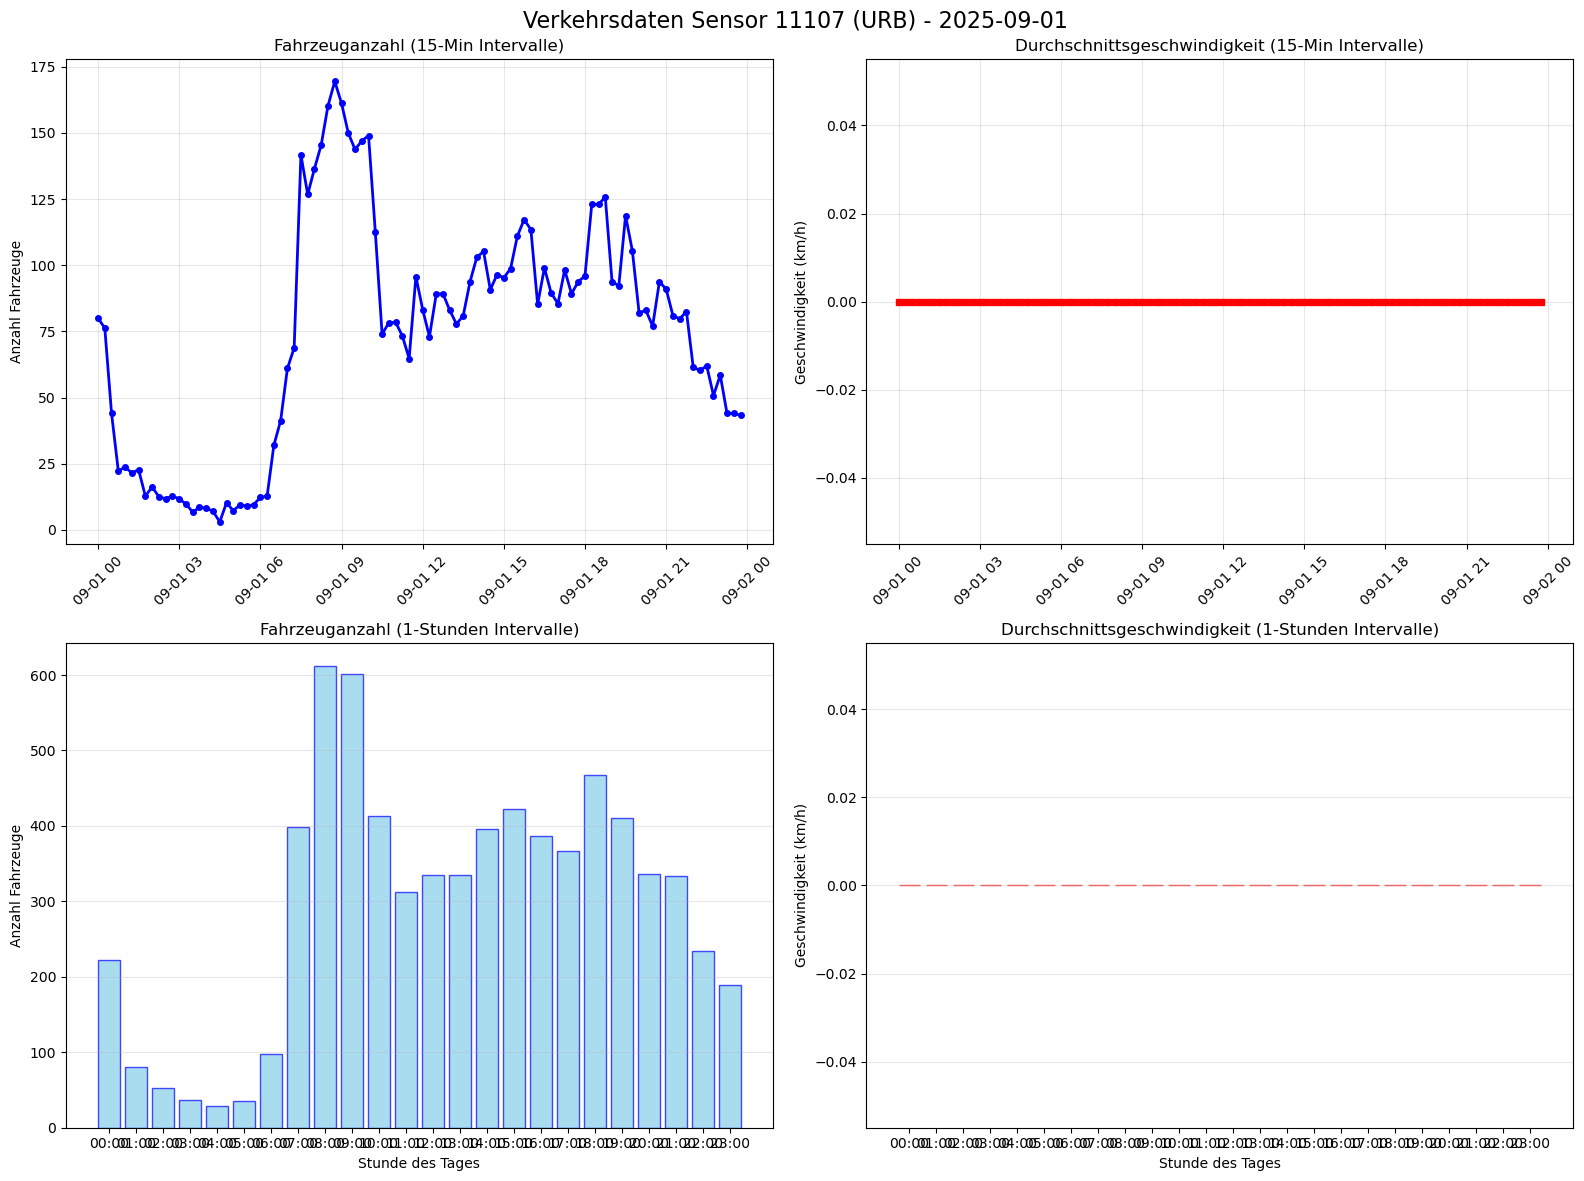


=== STATISTIKEN SENSOR 11107 am 2025-09-01 ===
Gesamte Fahrzeuge: 7107
Peak-Stunde (Fahrzeuge): 08:00 (612 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 00:00
Höchste Geschwindigkeit: 0.0 km/h um 00:00

--- MEDIAN_INTENSITY: Sensor 5331 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


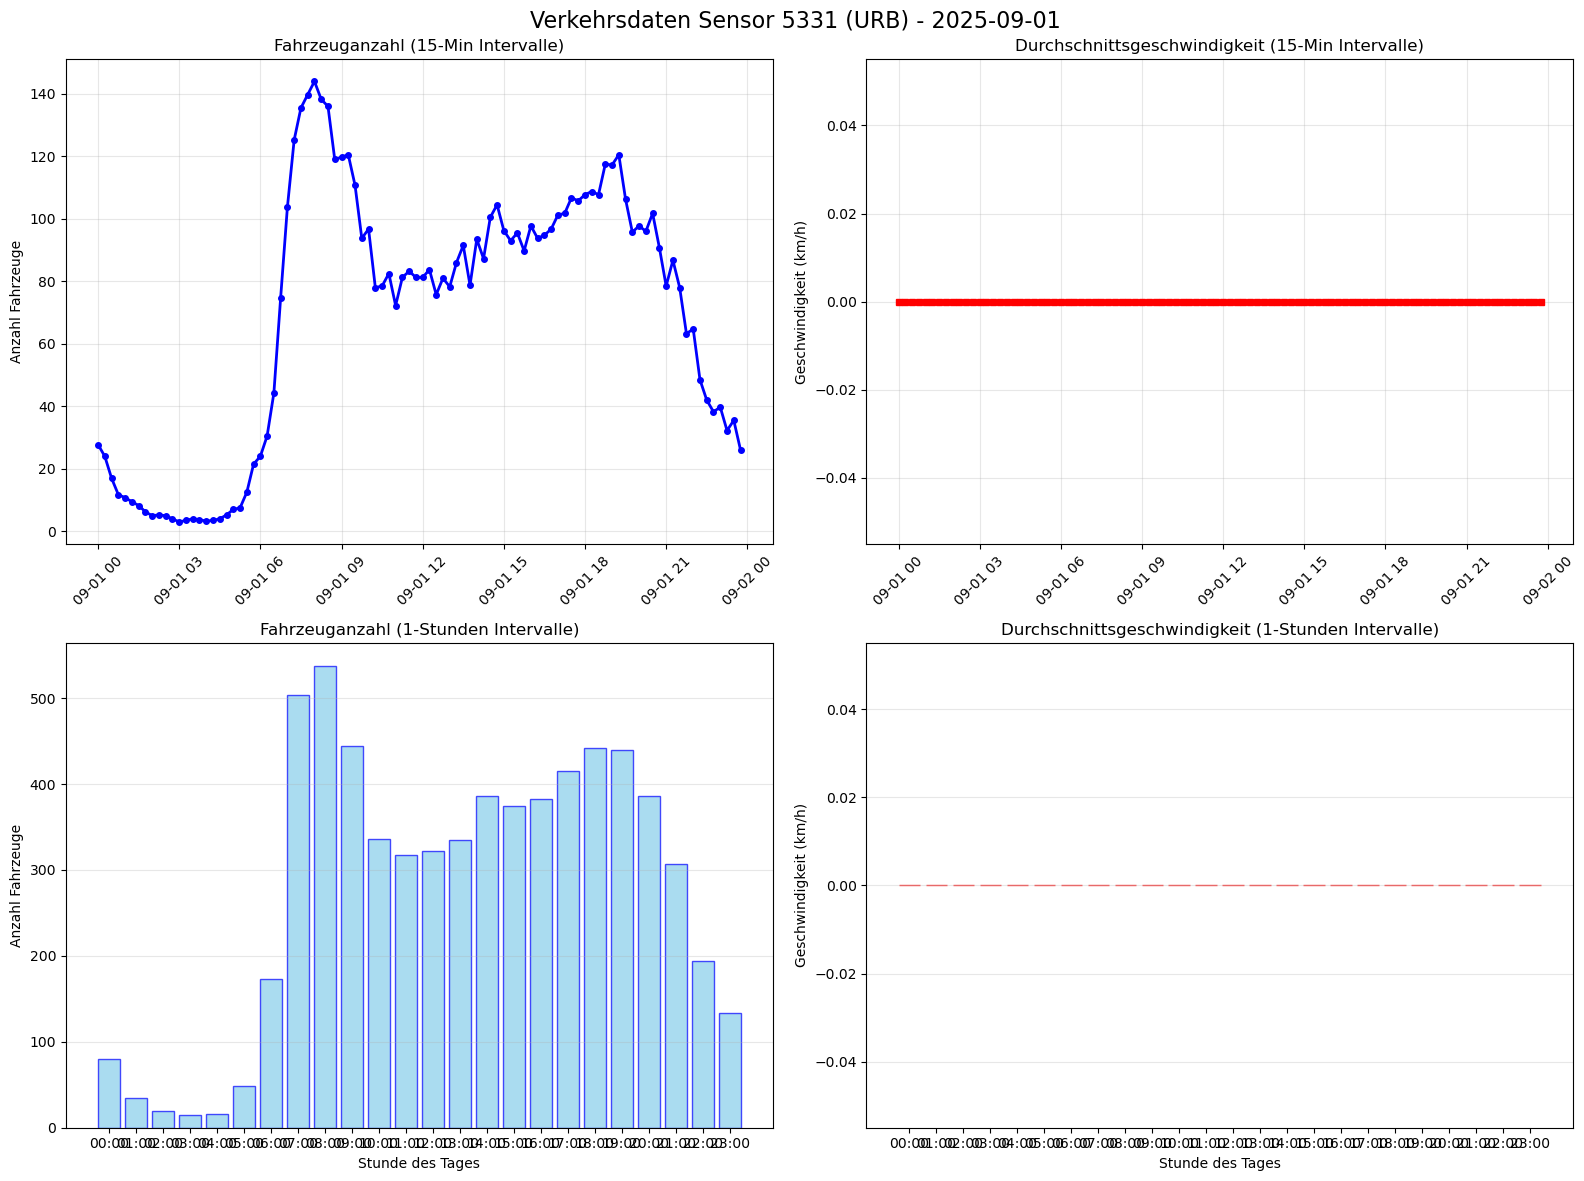


=== STATISTIKEN SENSOR 5331 am 2025-09-01 ===
Gesamte Fahrzeuge: 6643
Peak-Stunde (Fahrzeuge): 08:00 (537 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 00:00
Höchste Geschwindigkeit: 0.0 km/h um 00:00

--- MODE_INTENSITY: Sensor 3623 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


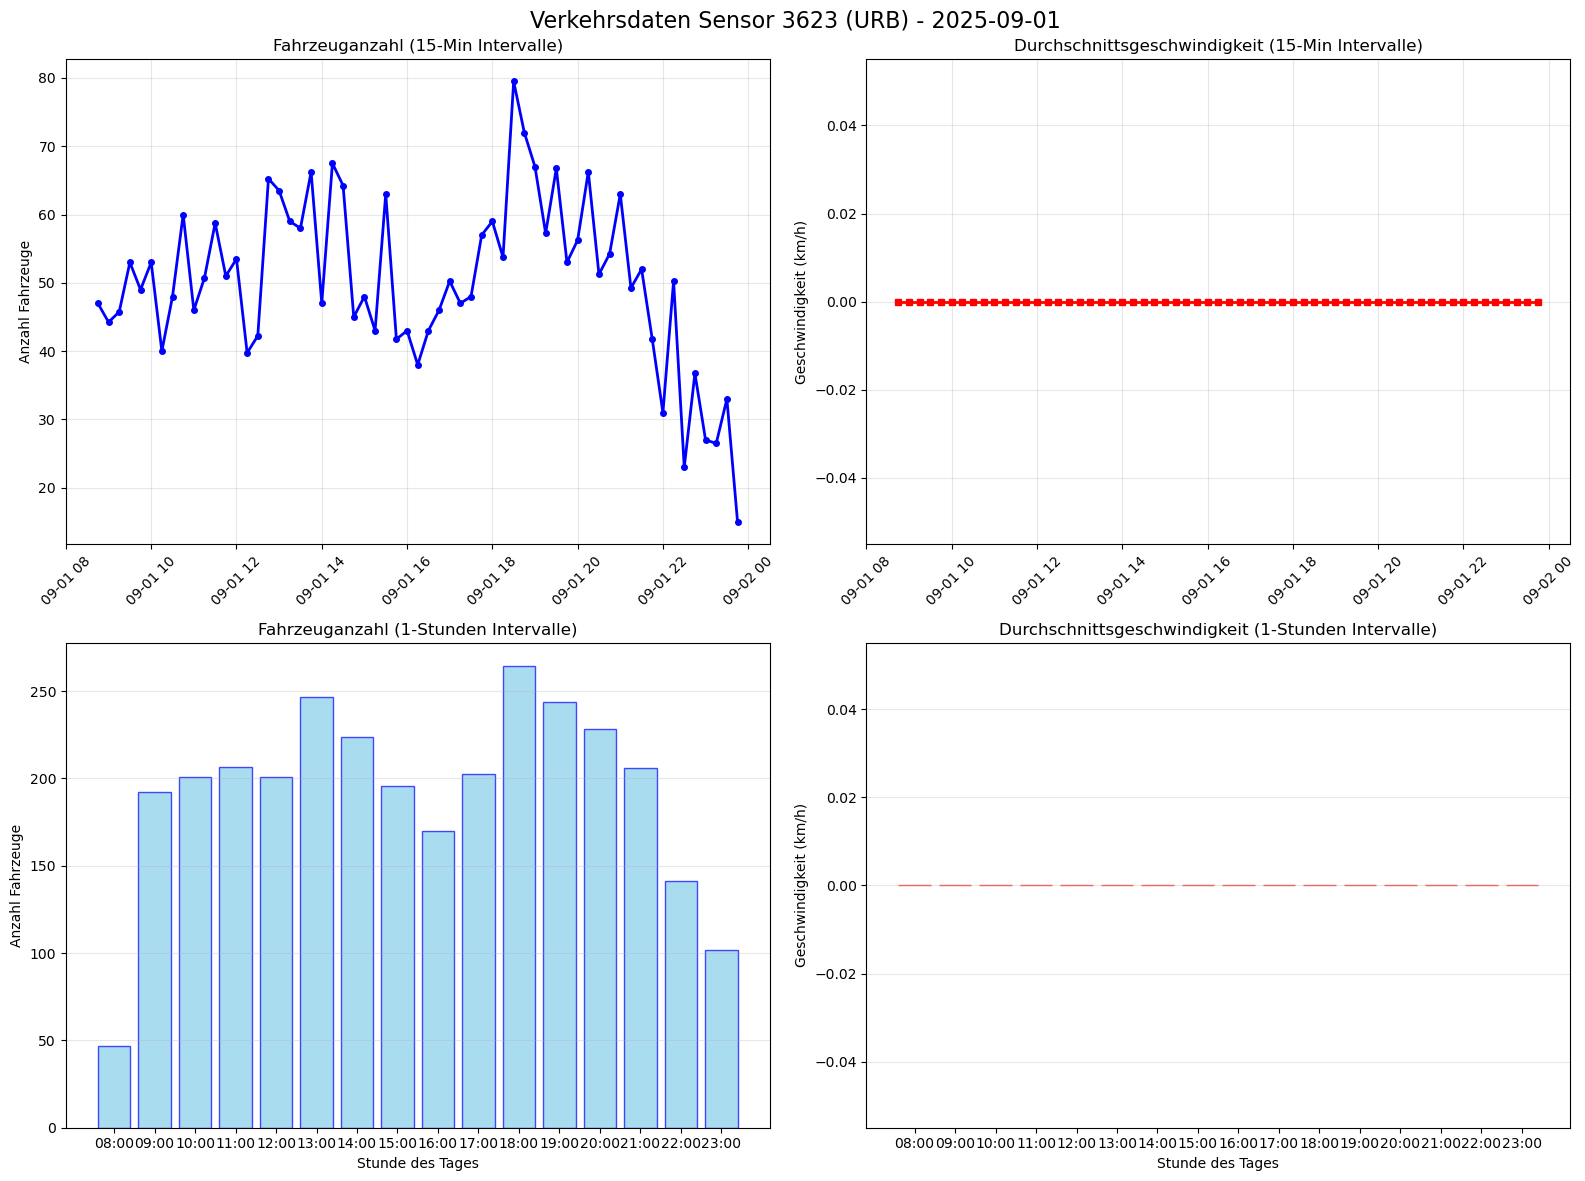


=== STATISTIKEN SENSOR 3623 am 2025-09-01 ===
Gesamte Fahrzeuge: 3070
Peak-Stunde (Fahrzeuge): 18:00 (264 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 08:45
Höchste Geschwindigkeit: 0.0 km/h um 08:45

--- MEAN_SPEED: Sensor 3395 ---


/var/folders/c4/czf4rs796r9_nl_qkrw4vc_r0000gn/T/ipykernel_6947/2403468368.py:36: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  data_1hour = daily_data.resample('H').agg({


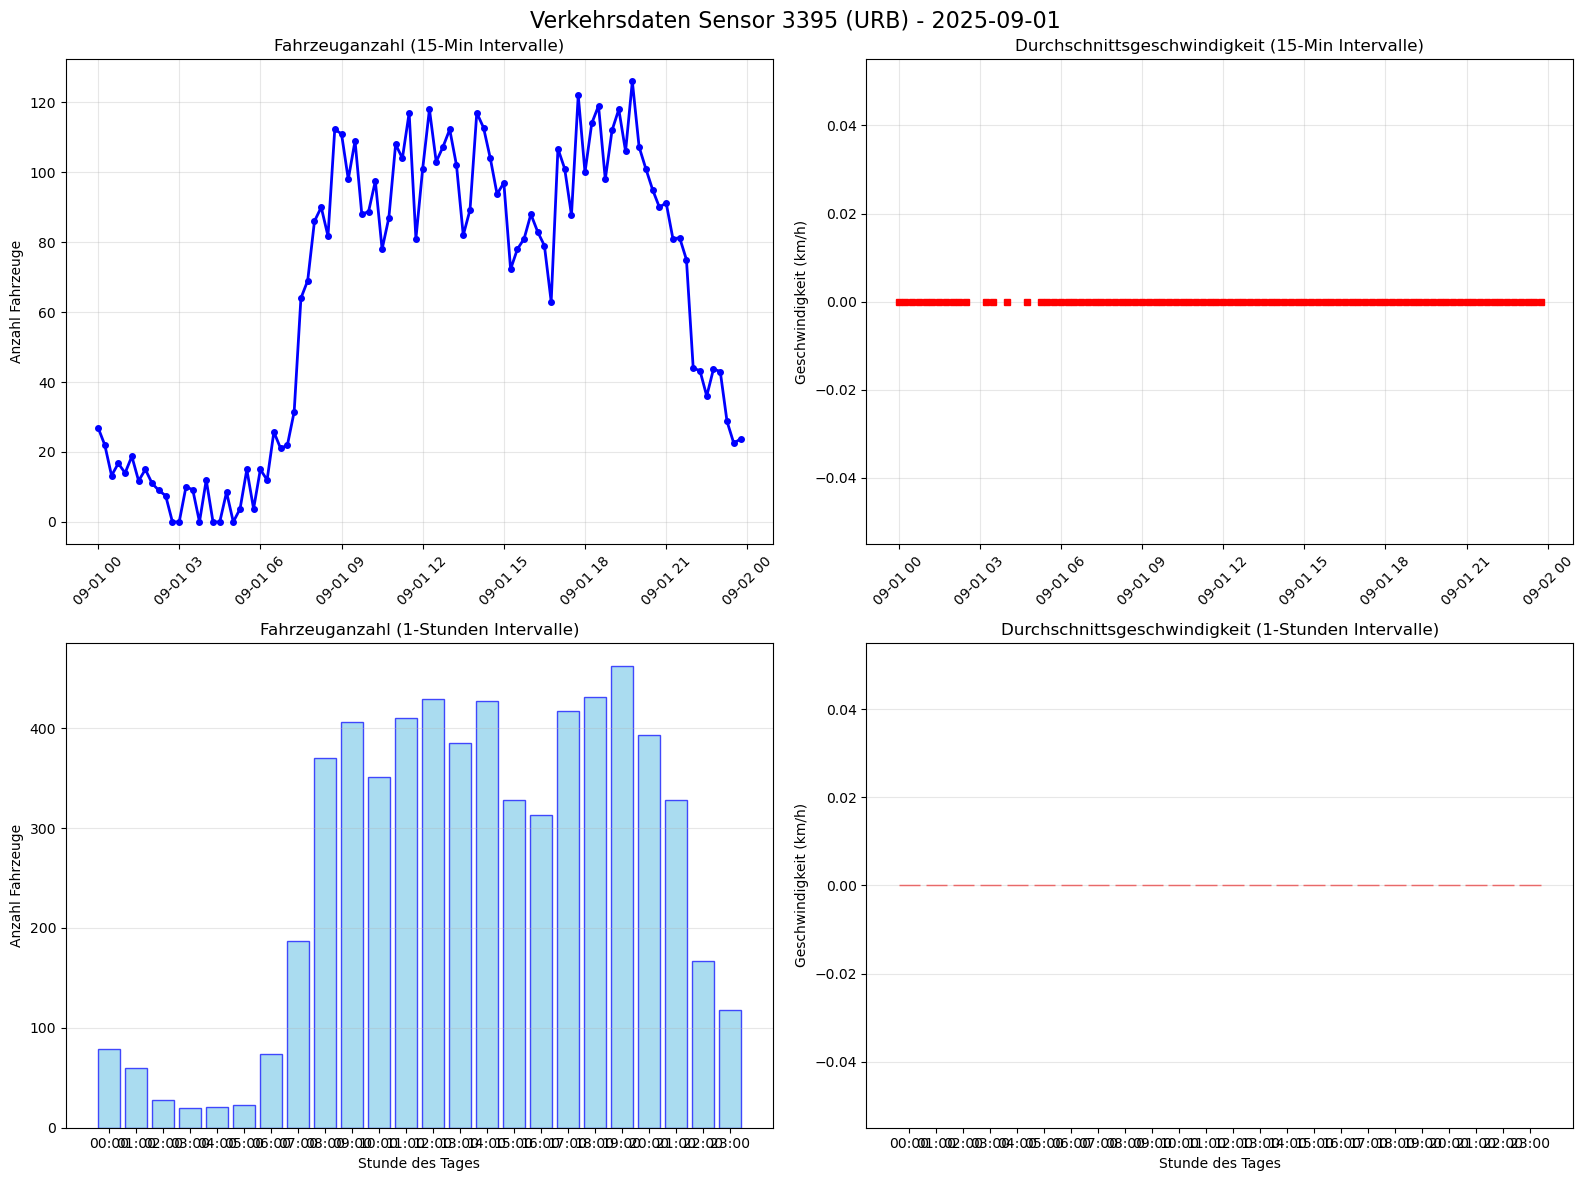


=== STATISTIKEN SENSOR 3395 am 2025-09-01 ===
Gesamte Fahrzeuge: 6226
Peak-Stunde (Fahrzeuge): 19:00 (462 Fahrzeuge)
Durchschnittsgeschwindigkeit: 0.0 km/h
Niedrigste Geschwindigkeit: 0.0 km/h um 00:00
Höchste Geschwindigkeit: 0.0 km/h um 00:00


In [85]:
def analyze_multiple_sensors(data, sensor_dict, sensor_type, date=None):
    """Analysiert mehrere relevante Sensoren"""
    
    print(f"\n=== ANALYSE ALLER RELEVANTEN {sensor_type} SENSOREN ===")
    
    for description, sensor_id in sensor_dict.items():
        print(f"\n--- {description.upper()}: Sensor {sensor_id} ---")
        plot_sensor_traffic(data, sensor_id, sensor_type, date)

# Alle relevanten M30-Sensoren analysieren
analyze_multiple_sensors(m30_data, m30_sensors, "M30")

# Alle relevanten URB-Sensoren analysieren  
analyze_multiple_sensors(urb_data, urb_sensors, "URB")